In [14]:
import zipfile
import cv2
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [15]:
# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    num_features = train_data.shape[1]  # 每个样本的特征维度
    
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
        
    return means  # 返回每个类别的均值矩阵

# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵

In [16]:
# 读取第一张灰度图像的大小作为图片形状，如果有图像大小不符合要求则使用以下代码进行缩放
# img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

# 读取图像数据
def read_images(dataset_dir):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数

    # 随机打乱数据集
    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels


In [17]:
data, labels, faceshape = read_images("attfaces")  # 读取图像数据和标签
print('Done images reading')  # 输出提示信息

train_data, train_labels, test_data, test_labels = train_test_split(data, labels, 0.5)  # 划分训练集和测试集
print('Done Train Test Split')  # 输出提示信息

classes_means = compute_classes_mean_matrix(train_data, train_labels)  # 计算每个类别的均值矩阵
print('Done classes means computing')  # 输出提示信息
print(classes_means.shape)  # 输出每个类别的均值矩阵的形状

overall_mean = compute_overall_mean_matrix(classes_means)  # 计算整体均值矩阵
print('Done overall mean computing')  # 输出提示信息
print(overall_mean.shape)  # 输出整体均值矩阵的形状

Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)  # 计算类间散布矩阵
print('Done between class scater matrix computing')  # 输出提示信息
print(Sb.shape)  # 输出类间散布矩阵的形状

Z = compute_center_class_matrix(train_data, train_labels, classes_means)  # 计算中心类别矩阵
print('Done center class scatter matrix computing')  # 输出提示信息
print(Z.shape)  # 输出中心类别矩阵的形状

Sw = compute_class_scatter_matrix(Z)  # 计算类内散布矩阵
print('Done within class scatter matrix computing')  # 输出提示信息
print(Sw.shape)  # 输出类内散布矩阵的形状

W_value = np.dot(np.linalg.inv(Sw), Sb)  # 计算投影矩阵W
print('Done W = S^(-1)B computing')  # 输出提示信息
print(W_value.shape)  # 输出投影矩阵W的形状

# 提取前40个最大特征值对应的特征向量
eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((10304-40),(10304-1)))  # 计算特征值和特征向量
print('Done eigen values and vectors computing')  # 输出提示信息
print(eigen_values.shape)  # 输出特征值的形状


Done images reading
Done Train Test Split
Done classes means computing
(40, 10304)
Done overall mean computing
(10304, 1)
Done between class scater matrix computing
(10304, 10304)
Done center class scatter matrix computing
(200, 10304)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_13508\2386802214.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引


Done within class scatter matrix computing
(10304, 10304)
Done W = S^(-1)B computing
(10304, 10304)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_13508\2307272353.py:32: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((10304-40),(10304-1)))  # 计算特征值和特征向量


Done eigen values and vectors computing
(40,)


Done eigen faces displaying


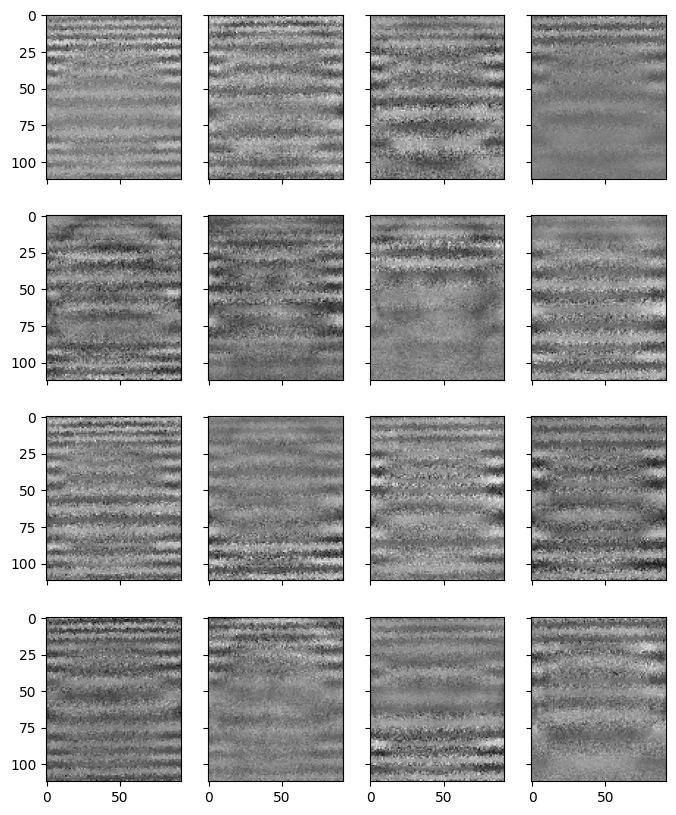

In [18]:
# 显示前16个特征脸
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(eigen_vectors[:,i].reshape(faceshape), cmap='gray')
print('Done eigen faces displaying')  # 输出提示信息
plt.show()  # 显示图像

In [19]:
# 测试要查询的图像
def test_query_class_sample(W, query_image, overall_mean, train_data):
    # 计算查询图像的线性判别函数值,即计算 d(Q) = W^T (Q - P)
    d = np.dot(W.T, (query_image - overall_mean))
    # 计算 ||d||
    discriminant_values = []
    for i in range(train_data.shape[0]):
        train_image = train_data[i]
        train_d = np.dot(W.T, (train_image - overall_mean))
        discriminant_value = np.linalg.norm(d - train_d)
        discriminant_values.append(discriminant_value)
    # 找到匹配的样本图像索引
    best_match_index = np.argmin(discriminant_values)
    # 可视化测试图像和最佳匹配图像
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(query_image.reshape(faceshape), cmap='gray')
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    axes[1].imshow(train_data[best_match_index].reshape(faceshape), cmap='gray')
    axes[1].set_title(f'Best Match Image (||d|| = {discriminant_values[best_match_index]:.2f})')
    axes[1].axis('off')
    plt.show()

    # 返回匹配结果
    return 0


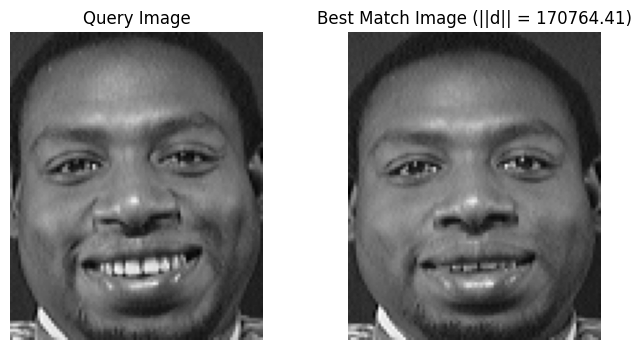

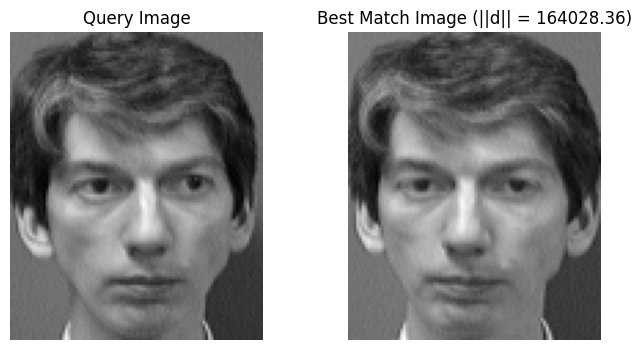

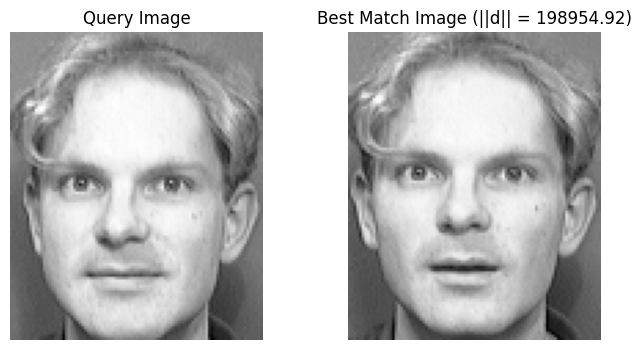

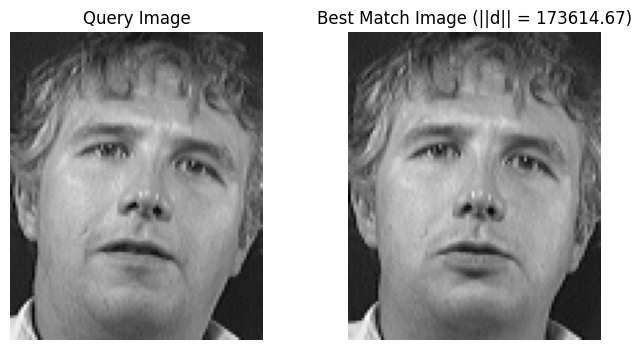

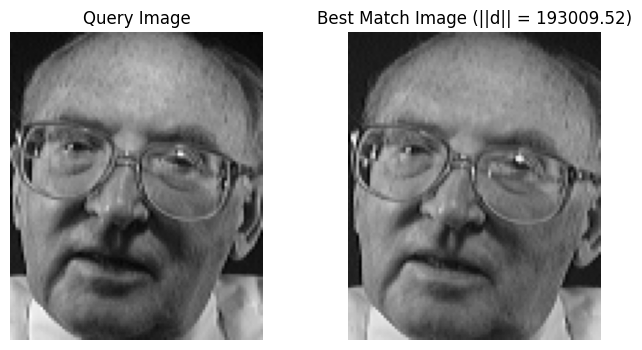

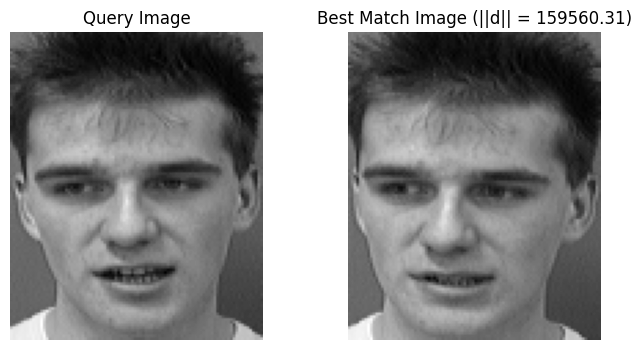

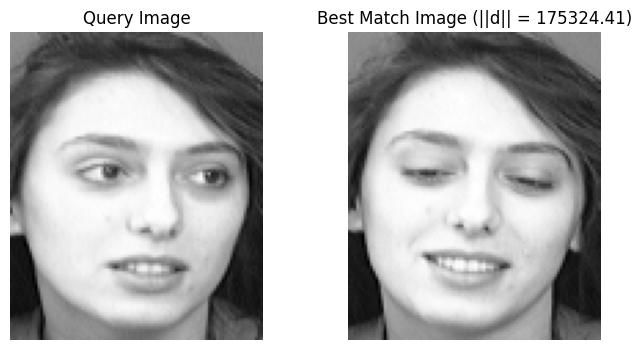

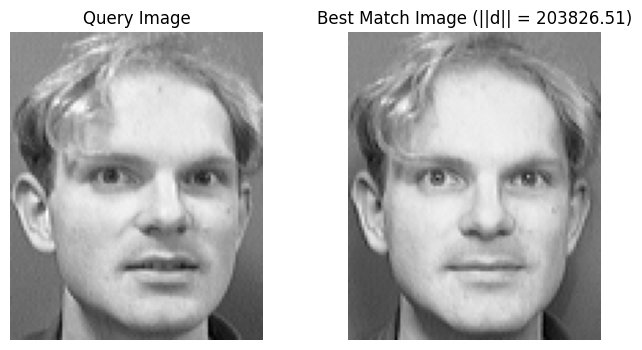

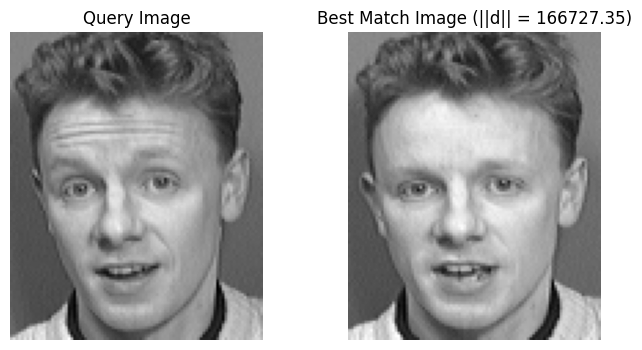

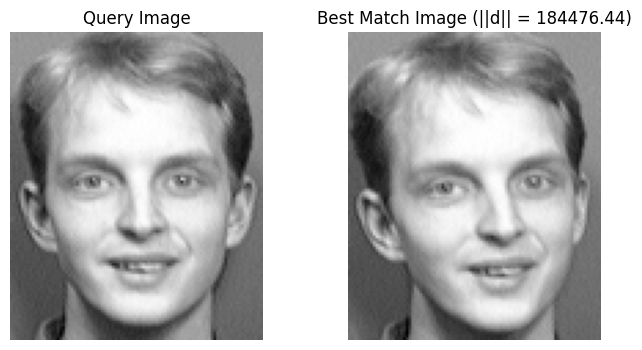

In [21]:
# 测试已存在类别的样本图像
for i in range(10):
    test_query_class_sample(eigen_vectors, test_data[i], overall_mean, train_data)